In [7]:
from commonfunctions import *
from skimage.filters import threshold_otsu, sobel
from skimage.morphology import binary_dilation, binary_opening, binary_closing, closing, erosion, dilation, remove_small_objects, disk
from skimage.feature import canny, corner_peaks, corner_harris
from skimage.measure import find_contours
from scipy.ndimage import binary_fill_holes

In [2]:
def get_gray(img):
    gray = rgb2gray(np.copy(img))
    return gray

In [3]:
def get_thresholded(img, thresh):
    return 1*(img > thresh)

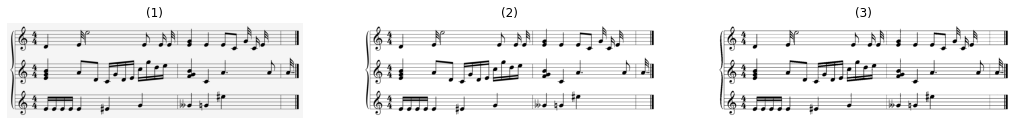

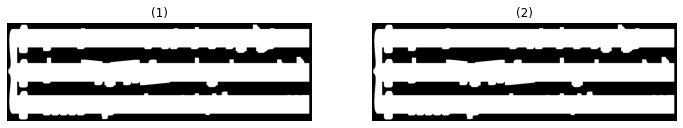

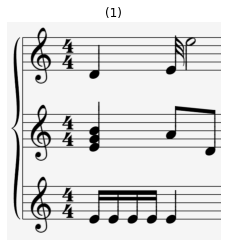

In [23]:
test_img = io.imread('dataset/02.PNG')
gray = get_gray(test_img)
bw = get_thresholded(gray, threshold_otsu(gray))
show_images([test_img, gray, bw])

se = np.ones((20, 20))
dilated = binary_dilation(1-bw, se)
# dilated = binary_closing(dilated, se)
opened = binary_opening(dilated, se)
show_images([dilated, opened])

conts = find_contours(opened, 0.8)
bboxes = []
for cont in conts:
    minr, minc, maxr, maxc = np.min(cont[:, 1]), np.min(cont[:, 0]), np.max(cont[:, 1]), np.max(cont[:, 0])
    bboxes.append((int(minr), int(minc), int(maxr), int(maxc)))

for box in bboxes:
    minr, minc, maxr, maxc = box
    show_images([test_img[minr:maxr, minc:maxc]])